# Hackathon

Some utilities

## Import Utils

In [1]:
!pip install keras

!pip install tables

    100% |################################| 337kB 3.0MB/s ta 0:00:01
    100% |################################| 256kB 3.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 4.6MB 334kB/s eta 0:00:01    28% |#########                       | 1.3MB 16.0MB/s eta 0:00:01    86% |###########################     | 4.0MB 32.7MB/s eta 0:00:01
    100% |################################| 399kB 3.9MB/s eta 0:00:01
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import keras
import h5py as h5
import numpy as np
import pandas as pd
import tables

PATH_DATA = '/notebooks/data/eighth.h5'
PATH_PREDICT_WITHOUT_GT = 'notebooks/data/pred_students/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = '/submit/pred_eighties_from_half_1_gr6.h5'
# PATH_PREDICT_WITH_GT = '/pred_teachers/pred_eighties_from_half_1.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [4]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [5]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [6]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [7]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [8]:
print(train_batch_count, val_batch_count)

58432 14608


In [10]:
label = h5.File(PATH_DATA)['TOP_LANDCOVER']
images = h5.File(PATH_DATA)['S2']

In [12]:
counts = np.zeros(23)
lbl = np.zeros(len(label))

for idx, value in enumerate(label):
    counts[int(value)] += 1
    lbl[idx] = value

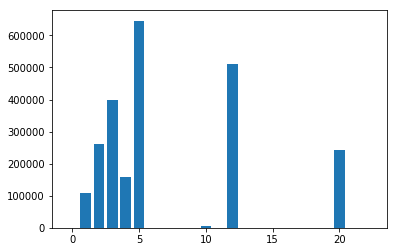

In [14]:
import matplotlib.pyplot as plt

plt.bar(np.arange(len(counts)), counts)
plt.show()

In [16]:
pd_lbl = pd.DataFrame(lbl)
pd_lbl.head()

,0
0,20.0
1,20.0
2,20.0
3,20.0
4,20.0


# Instanciation du model

In [27]:
input_shape = (16,16,4)

dropout_rate=0.5

model = Sequential()

model.add(Conv2D(32, (3,3),activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(23, activation='sigmoid'))

def top_3_accuracy(y_true, y_pred):
    return keras.top_k_categorical_accuracy(y_true, _y_pred, k=3)

# Fit

In [28]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy', top_3_accuracy ])

history = model.fit_generator(train_gen, steps_per_epoch=train_batch_count, epochs=1, verbose=1, validation_data=val_gen, nb_val_samples=1000)

AttributeError: module 'keras' has no attribute 'top_k_categorical_accuracy'

## Prediction routines

In order to submit a result here are some gits

In [16]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [17]:
prediction = model.predict_generator(val_gen, steps=val_batch_count, verbose=1)
print(len(prediction))


OSError: Unable to create file (unable to open file: name = '/pred_students/pred_eighties_from_half_1_without_gt.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = c2)

In [17]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

OSError: Unable to create file (unable to open file: name = '/pred_students/pred_eighties_from_half_1_without_gt.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = c2)

## Some ideas for monitoring

In [ ]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

In [ ]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)